<a href="https://colab.research.google.com/github/Arooba122/Multi_Model_Sentiment_Analysis/blob/master/text_classification_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1) reading of training dataset and testing dtaset**

In [ ]:
# specify the path for your drive where these dataset are located
import pandas as pd
data_train=pd.read_csv('/content/drive/My Drive/data_train.csv' , header=None )
data_test=pd.read_csv('/content/drive/My Drive/data_test.csv' , header=None )

**2) importing all the libraries**

In [ ]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense

In [ ]:
# reyrieving the desired columns 
df_train=pd.DataFrame(data_train)
df_test=pd.DataFrame(data_test)
X_train = df_train.iloc[1:,1]
X_test = df_test.iloc[1:,1]

y_train =df_train.iloc[1:,0]
y_test = df_test.iloc[1:,0]

data = data_train.append(data_test, ignore_index=True)

In [ ]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 5

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

**3) removal of hashtags and user names from dataset**

In [ ]:
def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

In [ ]:
import nltk
nltk.download('punkt')
texts = [' '.join(clean_text(text)) for text in data[1]]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**4) sequencing of inputs in to fix length so that modal reieve same size of inputs**

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 12088


In [ ]:
# saving the tokenizer for next use
import pickle
with open('/content/drive/My Drive/Sentiment_Analysis_text_model/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

**5) prepration of output labels through encoding**

In [ ]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

# Integer labels
y_train = [encoding[x] for x in df_train.iloc[1:,0]]
y_test = [encoding[x] for x in df_test.iloc[1:,0]]

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

**6) modal training and its calculation of accuracies**

In [ ]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
model = Sequential()
model.add(Embedding(vocab_size,embed_num_dims,input_length = max_seq_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64,activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64


hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/10
124/124 [==============================] - 226s 2s/step - loss: 1.3779 - accuracy: 0.3813 - val_loss: 1.2292 - val_accuracy: 0.5075
Epoch 2/10
124/124 [==============================] - 226s 2s/step - loss: 0.8464 - accuracy: 0.6940 - val_loss: 0.8391 - val_accuracy: 0.7003
Epoch 3/10
124/124 [==============================] - 230s 2s/step - loss: 0.4634 - accuracy: 0.8409 - val_loss: 0.8352 - val_accuracy: 0.7047
Epoch 4/10
124/124 [==============================] - 226s 2s/step - loss: 0.2961 - accuracy: 0.9060 - val_loss: 0.9248 - val_accuracy: 0.7047
Epoch 5/10
124/124 [==============================] - 227s 2s/step - loss: 0.2109 - accuracy: 0.9341 - val_loss: 1.0193 - val_accuracy: 0.7059
Epoch 6/10
124/124 [==============================] - 233s 2s/step - loss: 0.1653 - accuracy: 0.9524 - val_loss: 1.1817 - val_accuracy: 0.6888
Epoch 7/10
124/124 [==============================] - 228s 2s/step - loss: 0.1374 - accuracy: 0.9595 - val_loss: 1.1942 - val_accuracy: 0.6911

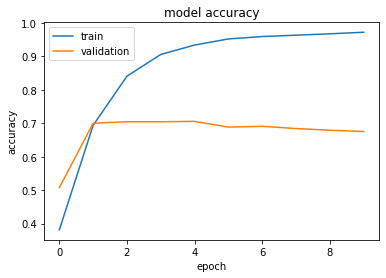

In [ ]:
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(df_test.iloc[1:,0], predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df_test.iloc[1:,0], predictions, average='micro') * 100))


Accuracy: 67.55%

F1 Score: 67.55


In [ ]:
import time

message = [' i love you like a love song']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

Message: [' i love you like a love song']
predicted: joy (0.09 seconds)


In [ ]:
test_loss, test_acc = model.evaluate(X_test_pad,y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

107/107 [==============================] - 13s 124ms/step - loss: 1.4456 - accuracy: 0.6755
Test Loss: 1.445631504058838
Test Accuracy: 0.6755083799362183


**7) saving my model in to drive**

In [ ]:
model.save('/content/drive/My Drive/Sentiment_Analysis_text_model/text_model_lstm.h5')

**8) loading my model from drive**

In [ ]:
from keras.models import load_model
modell = load_model('/content/drive/My Drive/Sentiment_Analysis_text_model/text_model_lstm.h5')

In [ ]:
# loading tokenizer 
import pickle
with open('/content/drive/My Drive/Sentiment_Analysis_text_model/tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

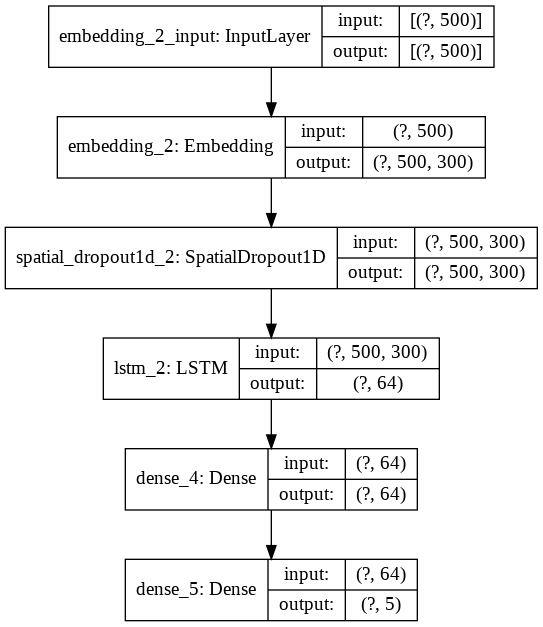

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(modell, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**9)srt fie reading and its converion in to text from and cleansing of its textual data**

In [ ]:
# retrieval of .srt file and its conversion in test
file = open( "/content/drive/My Drive/sample.srt", "r")
lines = file.readlines()
print(lines)
print(type(lines[1]))
print(lines[1])
file.close()
import re

text = ''
for line in lines:
    if re.search('^[0-9]+$', line) is None and re.search('^[0-9]{2}:[0-9]{2}:[0-9]{2}', line) is None and re.search('^$', line) is None:
            text += ' ' + line.rstrip('\n')
    text = text.lstrip()
print(text)

['\ufeff1\n', '00:00:36,320 --> 00:00:40,799\n', '<i>I believe we have a choice in this\n', 'world about how to tell sad stories.</i>\n', '\n', '2\n', '00:00:40,800 --> 00:00:43,639\n', '<i>On the one hand,\n', 'you can sugarcoat it.</i>\n', '\n', '3\n', '00:00:43,640 --> 00:00:46,239\n', '<i>The way they do in movies\n', 'and romance novels...</i>\n', '\n', '4\n', '00:00:46,240 --> 00:00:49,799\n', '<i>where beautiful people\n', 'learn beautiful lessons...</i>\n', '\n', '5\n', '00:00:49,800 --> 00:00:52,079\n', '<i>where nothing is too messed\n', "up that can't be fixed...</i>\n", '\n', '6\n', '00:00:52,080 --> 00:00:54,603\n', '<i>with an apology\n', 'and a Peter Gabriel song.</i>\n', '\n', '7\n', '00:00:54,960 --> 00:00:57,319\n', '<i>I like that version as much\n', 'as the next girl does,</i>\n', '\n', '8\n', '00:00:57,320 --> 00:00:59,081\n', '<i>believe me.</i>\n', '\n', '9\n', '00:00:59,600 --> 00:01:01,929\n', "<i>It's just not the truth.</i>\n", '\n', '10\n', '00:01:02,680 -->

In [ ]:
print(len(text))
print(type(text))
text=text.split('.')

852
<class 'str'>


In [ ]:
print(len(text))
print(text)

print(text[1])
text_1=[]
for i in range(len(text)):

   li = list(text[i].split(" "))
   text_1.append(li)

27
['\ufeff1 <i>I believe we have a choice in this world about how to tell sad stories', '</i> <i>On the one hand, you can sugarcoat it', '</i> <i>The way they do in movies and romance novels', '', '', '</i> <i>where beautiful people learn beautiful lessons', '', '', "</i> <i>where nothing is too messed up that can't be fixed", '', '', '</i> <i>with an apology and a Peter Gabriel song', '</i> <i>I like that version as much as the next girl does,</i> <i>believe me', "</i> <i>It's just not the truth", '</i> <i>This is the truth', '</i> <i>Sorry', '</i> <i>Late in the winter of my seventeenth year', '', '', '</i> <i>my mother decided that I was depressed', '</i> She just eats like a bird, she barely leaves the house', ' I am not depressed, Mom', " She's reading the same book over and over", " She's depressed", " I'm not depressed", ' <i>The booklets and the websites always list depression as</i> <i>a side effect of cancer', '</i>']
</i> <i>On the one hand, you can sugarcoat it


In [ ]:
print(text_1[1])

['</i>', '<i>On', 'the', 'one', 'hand,', 'you', 'can', 'sugarcoat', 'it']


In [ ]:
# removal of stop words from sentiments..
import nltk
import numpy
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('stopwords')
# from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
removed=[]
#text=c[0][0]
# c=content.str.split(" ")
for i in range (len(text_1)):
  for j in range (len(text_1[i])):


     x=" "
     text2= [w for w in text_1[i] if not w in stop_words]
#     for w in c[i]: 
  removed.append(text2)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#removal of special characters and spaces from the content 
# stamming is also performed here
re=[]
from nltk.stem import PorterStemmer
nltk.download('averaged_perceptron_tagger')
porter = PorterStemmer()
for i in range(len(removed)):
  
      
    files = removed[i]
    result = ["".join(list(filter(str.isalnum, line))) for line in files]
    result = list(filter(str.strip, result))
    # for r in range (len(result)):
    #    result[r]=porter.stem(result[r])
  # result=nltk.pos_tag(result)
    re.append(result)
# print(re)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
#removal of empty lists from list ..
list_text = [x for x in re if x]

In [ ]:
# post tagging application
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet

from IPython.display import display

lemmatizer = nltk.WordNetLemmatizer()

#word tokenizeing and part-of-speech tagger


# Rule for NP chunk and VB Chunk
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        {<RB.?>*<VB.?>*<JJ>*<VB.?>+<VB>?} # Verbs and Verb Phrases
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
        
"""
#Chunking
cp = nltk.RegexpParser(grammar)

def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label() =='NP'):
        yield subtree.leaves()
        
def get_word_postag(word):
    if pos_tag([word])[0][1].startswith('J'):
        return wordnet.ADJ
    if pos_tag([word])[0][1].startswith('V'):
        return wordnet.VERB
    if pos_tag([word])[0][1].startswith('N'):
        return wordnet.NOUN
    else:
        return wordnet.NOUN
    
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    postag = get_word_postag(word)
    word = lemmatizer.lemmatize(word,postag)
    return word

def get_terms(tree):    
    for leaf in leaves(tree):
        terms = [normalise(w) for w,t in leaf]
        yield terms


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
xyz=[['iI believe choice world tell sad stories'],['i iwhere nothing messed cant fixed']]
text_predicted=[]
for i in range (len(list_text)):
  s = list_text[i]
  listToStr = ' '.join([str(elem) for elem in s])

  document = listToStr
  tokens = [nltk.word_tokenize(sent) for sent in [document]]
  postag = [nltk.pos_tag(sent) for sent in tokens][0]


# the result is a tree
  tree = cp.parse(postag)
  terms = get_terms(tree)

  features = []
  for term in terms:
      _term = ''
      for word in term:
          _term += ' ' + word
      features.append(_term.strip())
  text_predicted.append(features)
print(text_predicted)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[['ii believe choice world', 'tell', 'sad story'], ['i ion', 'hand sugarcoat'], ['i', 'ithe', 'way movie romance novel'], ['i', 'beautiful people', 'learn', 'beautiful lesson'], ['i', 'nothing', 'mess', 'cant', 'fix'], ['i', 'iwith', 'apology peter gabriel song'], ['i ii', 'version', 'next girl doesi', 'ibelieve'], ['i iits', 'truth'], ['i', 'ithis', 'truth'], ['i', 'isorry'], ['i', 'ilate', 'winter seventeenth year'], ['i imy', 'mother', 'decide', 'depressed'], ['i', 'eats', 'bird', 'barely leaf', 'house'], ['depressed', 'mom'], ['shes', 'reading', 'book'], ['shes', 'depressed']

**10) sentiment analysis performed on srt fiile **

In [ ]:
import time

array_emotions=[]
for p in range(len(text_predicted)):

   s = text_predicted[p] 
   listToStr = ' '.join([str(elem) for elem in s])

   listToStr = ' '.join([str(elem) for elem in s])
   message = [listToStr]
    # print(type(message))
    # print(message)
  
   seq = loaded_tokenizer.texts_to_sequences(message)
   padded = pad_sequences(seq, maxlen=max_seq_len)
   start_time = time.time()
   pred = modell.predict(padded)

   print('Message: ' + str(message))
   print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))
   v=np.argmax(pred)

   z=class_names[v]
   array_emotions.append(z)
print(array_emotions)

Message: ['ii believe choice world tell sad story']
predicted: sadness (0.50 seconds)
Message: ['i ion hand sugarcoat']
predicted: neutral (0.08 seconds)
Message: ['i ithe way movie romance novel']
predicted: fear (0.08 seconds)
Message: ['i beautiful people learn beautiful lesson']
predicted: fear (0.08 seconds)
Message: ['i nothing mess cant fix']
predicted: anger (0.08 seconds)
Message: ['i iwith apology peter gabriel song']
predicted: sadness (0.08 seconds)
Message: ['i ii version next girl doesi ibelieve']
predicted: anger (0.08 seconds)
Message: ['i iits truth']
predicted: neutral (0.09 seconds)
Message: ['i ithis truth']
predicted: neutral (0.08 seconds)
Message: ['i isorry']
predicted: neutral (0.08 seconds)
Message: ['i ilate winter seventeenth year']
predicted: joy (0.08 seconds)
Message: ['i imy mother decide depressed']
predicted: sadness (0.08 seconds)
Message: ['i eats bird barely leaf house']
predicted: joy (0.08 seconds)
Message: ['depressed mom']
predicted: sadness (0.

**11) visula represntation of how many perecent of each sentiment is there in srt file**

In [ ]:

joy_c=array_emotions.count("joy")
print(joy_c)
neutral_c=array_emotions.count("neutral")
print(neutral_c)
sad_c=array_emotions.count("sadness")
print(sad_c)
angry_c=array_emotions.count("anger")
print(angry_c)
fear_c=array_emotions.count("fear")
print(fear_c)

3
6
6
2
2


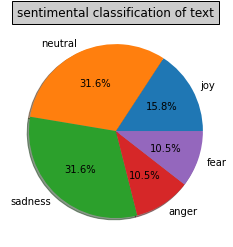

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
from pylab import figure, axes, pie, title, show
from google.colab import files as fl
# Data to plot
labels = 'joy', 'neutral', 'sadness', 'anger','fear'
fracs = [joy_c, neutral_c, sad_c, angry_c,fear_c]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','red']
explode = (0, 0, 0,0,0)
pie(fracs, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
title('sentimental classification of text', bbox={'facecolor': '0.8', 'pad': 5})


plt.savefig("abc.png")
show("abc.png")
fl.download("abc.png")